In [1]:
using GraphPPL, Rocket, ReactiveMP
using Random, Distributions, LinearAlgebra
using Plots

## Solving GP Regression by SDE
In this notebook, we use kernel Matern-5/2. Recall the definition of Matern kernel:
$$
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
$$

and the state-space model:
$$
\mathbf{f}_k = \mathbf{A}_{k-1} \, \mathbf{f}_{k-1} + \mathbf{q}_{k-1}, \quad \mathbf{q}_{k-1} \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_{k-1}) \\
y_k = \mathbf{H} \, \mathbf{f}(t_k) + \epsilon_k , \quad \epsilon_k \sim \mathcal{N}(0, \sigma^2_{noise}).
$$
The matrices for the SDE representation of the Matern-52 are:
$$
\mathbf{F} = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1 \\
-\lambda^3 & -3\lambda^2 & -3\lambda
\end{pmatrix} ,\quad \quad \mathbf{L} = \begin{pmatrix}
0 \\ 0 \\ 1
\end{pmatrix}, \quad \quad \mathbf{H} = \begin{pmatrix}
1 & 0 & 0
\end{pmatrix}, \quad \quad Q_c = \frac{16}{3} \sigma^2 \lambda^5, 
$$
where $\lambda = \sqrt{5} / l$. To find $\mathbf{P}_\infty$, we solve the Lyapunov equation
$$
\frac{d\mathbf{P}_\infty}{dt} = \mathbf{F} \mathbf{P}_\infty + \mathbf{P}_\infty \mathbf{F}^T + \mathbf{L} \mathbf{Q}_c \mathbf{L}^T = 0,
$$
and the solution of the equation is
$$ 
vec(\mathbf{P}_\infty) = (\mathbf{I} \otimes \mathbf{F} + \mathbf{F}\otimes\mathbf{I})^{-1}\, vec(-\mathbf{L}Q_c\mathbf{L}^T)
$$   
where $vec(.)$ is the vectorization operator and $\otimes$ denotes the Kronecker product. Now we can find $\mathbf{A}_k$ and $\mathbf{Q}_k$ 
$$
\mathbf{A}_k = \exp{(\mathbf{F}\Delta t_k)} \\
\mathbf{Q}_k = \mathbf{P}_\infty - \mathbf{A}_k \mathbf{P}_\infty \mathbf{A}_k^T  
$$

In [2]:
L = [0. ,0., 1.];
H = [1., 0., 0.];
function SDEmatrices(θ)
    #θ = [σ, l]
    λ = sqrt(5)/θ[2];
    F = [0. 1. 0.; 0. 0. 1.; -λ^3 -3λ^2 -3λ]
    Qc = 16/3 * θ[1]^2 * λ^5;
    I = diageye(3) ; #identity matrix
    vec_P = inv(kron(I,F) + kron(F,I)) * vec(-L * Qc * L'); 
    P∞ = reshape(vec_P,3,3);

    return F, P∞
end

SDEmatrices (generic function with 1 method)

## Specify model

In [8]:
@model function gp_regression(n, t_obser, t, F,P∞, var_noise)
    Δt = [t[1]]; #This stores time differences
    append!(Δt, t[2:end] - t[1:end-1]);
    T = length(t); # t is the whole timeline

    f_0 ~ MvNormalMeanCovariance(zeros(3), P∞)
    f = randomvar(T)
    y = datavar(Float64,n)
    f_prev = f_0

    for i=1:T
        if i < T 
        #check if we have observation at this time step
            if t[i] in t_obser
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                #find position of t[i] in t_obser 
                position = findall(x->x==t[i], t_obser)[]
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                y[position] ~ NormalMeanVariance(dot(H , f[i]), var_noise)
                f_prev = f[i]
            else
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                f_prev = f[i]
            end
        else
            if t[i] in t_obser
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                #find position of t[i] in t_obser 
                position = findall(x->x==t[i], t_obser)[]
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                y[position] ~ NormalMeanVariance(dot(H , f[i]), var_noise)
                f_prev = f[i]
            else
                A = exp(F * Δt[i]); # this depends on Δt
                Q = P∞ - A*P∞*A';
                f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
                f[i] ~ Uninformative()
            end
        end
    end

    return f, y
end

## Inference

In [9]:
function infer(data,t_obser, t,F,P∞, var_noise)
    n = length(data)
    model, (f,y) = gp_regression(n,t_obser, t,F,P∞, var_noise)
    
    f_buffer = buffer(Marginal, length(t)) #error here (maybe)

    f_subscribed = subscribe!(getmarginals(f), f_buffer) #error here

    update!(y,data)

    unsubscribe!(f_subscribed)

    return f_buffer
end

infer (generic function with 1 method)

## Generate data

In [44]:
#generate data
Random.seed!(10)
timeline = collect(range(0, 5, length=100)); #input
f_true = 2*sin.(timeline) .+ cos.(2*timeline); # true process

pos = sort(randperm(75)[1:2:75]); # position where we observe data
time_obser = timeline[pos]; # x-positions of observed point
σ²_noise = 0.2;
y_obser = f_true[pos] + σ²_noise*randn(length(time_obser)); # noisy observation

θ = [1., 1.]; # store [l, σ²]
F, P∞ = SDEmatrices(θ);

In [45]:
#Addtitional rule for MvNormalMeanCovariance
@rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out::Missing, q_Σ::PointMass, ) = begin 
    return missing 
end

#Additional rule for multiplication
@rule typeof(*)(:in, Marginalisation) (m_out::Missing, m_A::PointMass, meta::TinyCorrection) = begin 
    return missing 
end

In [46]:
f_posterior = infer(y_obser, time_obser, timeline, F,P∞, σ²_noise);

In [47]:
m_f = Array{Array{Float64}}(undef, length(timeline))
cov_f = Array{Array{Float64}}(undef, length(timeline))
for i=1:length(timeline)
    m_f[i] = mean_cov.(f_posterior)[i][1]
    cov_f[i] = mean_cov.(f_posterior)[i][2]
end
M_F = hcat(m_f...);

var_f = []
for i=1:length(timeline)
    append!(var_f,cov_f[i][1])
end



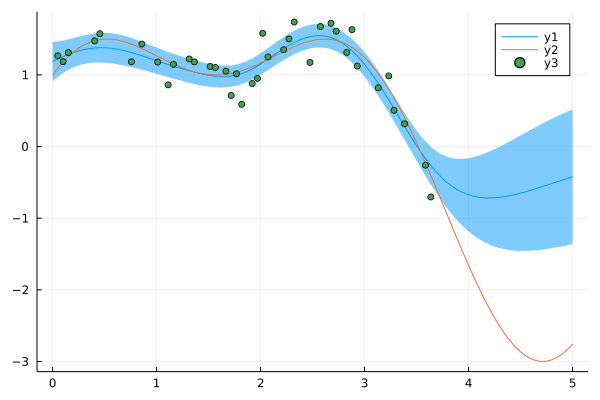

In [48]:
plot(timeline, M_F[1,:], ribbon = sqrt.(var_f))
plot!(timeline,f_true)
scatter!(time_obser,y_obser)